## Solving an XOR problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions

In [2]:
# Generate data

# Generate 200 examples. Each example has two features within [-1, 1)
#np.random.seed(1)
num_example = 200
X = np.random.uniform(low=-1, high=1, size=(num_example,2))

# Generate binary labels (0 and 1)
# Initialize the labels to be ones
y = np.ones(len(X))
# Set some labels to be zeros
y[X[:,0] * X[:,1] <0] = 0
# Note that X[:,0] and X[:,1] are 1D arrays, so they can be used to generate boolean indices to modify y
# Both X[:,0] and X[0,:] are 1D arrays.

# Also note that the type of y is float64, not int.

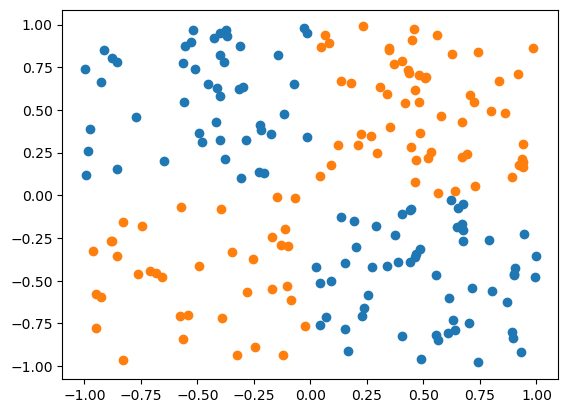

In [3]:
# Visualize the data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[y==0, 0], X[y==0, 1])
ax.scatter(X[y==1, 0], X[y==1, 1])
# It can be seen that the data cannot be separated by any straight line.

In [4]:
# Use sklearn to split data
X_train_np, X_valid_np, y_train_np, y_valid_np = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [5]:
# Split data
# 100 training examples
num_train = 100 
X_train = torch.tensor(X[:num_train, :], dtype=torch.float32)
X_valid = torch.tensor(X[num_train:, :], dtype=torch.float32)
# Without dtype=torch.float32, the type of these data will be float64. 
# This is because the tensors are created from X, which is float64.


y_train = torch.tensor(y[:num_train], dtype=torch.float32)
y_valid = torch.tensor(y[num_train:], dtype=torch.float32)
# Note that the labels are also converted into float32.
# The reason that we do not use int for the labels is that later we will calculate loss
# The loss function only acccept float labels.

'''
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)

X_valid = torch.tensor(X_valid_np, dtype=torch.float32)
y_valid = torch.tensor(y_valid_np, dtype=torch.float32)

'''


'\nX_train = torch.tensor(X_train_np, dtype=torch.float32)\ny_train = torch.tensor(y_train_np, dtype=torch.float32)\n\nX_valid = torch.tensor(X_valid_np, dtype=torch.float32)\ny_valid = torch.tensor(y_valid_np, dtype=torch.float32)\n\n'

In [6]:
# Define a single layer network, which is essentially logistic regression
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
    torch.nn.Sigmoid()
)
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [7]:
# Define loss function and optimizer
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# model.parameters() is a generator, see the cell below

In [8]:
# Use a for loop to see what model.parameters contains.
for item in model.parameters():
    print(item)

Parameter containing:
tensor([[ 0.3841, -0.1740]], requires_grad=True)
Parameter containing:
tensor([-0.2636], requires_grad=True)


In [9]:
# More explanation on the loss function
# The first argument of the loss function contains predicted class probabilities
# The second argument contains the true class labels
# It is very important that the two argument must have the same shape
# Either we use 1D tensor for both arguments, or column tensors (2D tensors with a single column)
# Therefore, the following two ways are both correct.

# In this method, .view(-1,1) reshape y_train to turn it into a column tensor
pred = model(X_train)
loss = loss_fn(pred, y_train.view(-1, 1))
print(loss)

# In this method, [:, 0] extracts the column in X_train and the result is a 1D tensor.
pred = model(X_train)[:,0]
loss = loss_fn(pred, y_train)
print(loss)

# The following codes will not work, since the two arguments have difference shapes.
# pred = model(X_train)
# loss = loss_fn(pred, y_train)

tensor(0.7175, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7175, grad_fn=<BinaryCrossEntropyBackward0>)


In [10]:
# Create dataset
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)

# Create dataloader
torch.manual_seed(1)
batch_size = 2 # batch_size will be used later, so we prepare a variable for it.
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [11]:
# Train the model

num_epoch = 500
num_batch = num_train/batch_size

loss_history_train = np.zeros(num_epoch)
accuracy_history_train = np.zeros(num_epoch)

loss_history_valid = np.zeros(num_epoch)
accuracy_history_valid = np.zeros(num_epoch)


for epoch in range(num_epoch):
    for X_batch, y_batch in dataloader_train:
        pred = model(X_batch)[:,0] # See one cell above for why using [:,0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_history_train[epoch] += loss.item()
        # pred>0.5 returns a boolean tensor, we need to convert it to float32 in order to compare it with y_batch.
        # .float() converts the tensor into float32
        # The .float() at the end turns is_correct into a float32 tensor. 
        # We must do this, otherwise we cannot take its mean by using .mean()
        is_correct = ((pred>0.5).float() == y_batch).float()
        accuracy_history_train[epoch] += is_correct.mean()
        
    loss_history_train[epoch] /= num_batch
    accuracy_history_train[epoch] /= num_batch
    
    pred = model(X_valid)[:,0]
    loss = loss_fn(pred, y_valid)
    loss_history_valid[epoch] = loss.item()
    is_correct = ((pred>0.5).float() == y_valid).float() 
    accuracy_history_valid[epoch] = is_correct.mean()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss_history_train[epoch]} Accuracy {accuracy_history_train[epoch]}")

Epoch 0, Loss 0.7174799555540085 Accuracy 0.37
Epoch 10, Loss 0.7144301050901413 Accuracy 0.37
Epoch 20, Loss 0.7118098425865174 Accuracy 0.38
Epoch 30, Loss 0.7095193058252335 Accuracy 0.38
Epoch 40, Loss 0.7075206863880158 Accuracy 0.39
Epoch 50, Loss 0.7058055007457733 Accuracy 0.39
Epoch 60, Loss 0.7042307996749878 Accuracy 0.39
Epoch 70, Loss 0.702877436876297 Accuracy 0.39
Epoch 80, Loss 0.7016805160045624 Accuracy 0.39
Epoch 90, Loss 0.7005944585800171 Accuracy 0.39
Epoch 100, Loss 0.6996193957328797 Accuracy 0.41
Epoch 110, Loss 0.6987553191184998 Accuracy 0.41
Epoch 120, Loss 0.6979674899578094 Accuracy 0.44
Epoch 130, Loss 0.6972583222389221 Accuracy 0.46
Epoch 140, Loss 0.696610473394394 Accuracy 0.49
Epoch 150, Loss 0.6960302007198333 Accuracy 0.52
Epoch 160, Loss 0.6954961133003235 Accuracy 0.54
Epoch 170, Loss 0.6950131714344024 Accuracy 0.58
Epoch 180, Loss 0.6945590054988862 Accuracy 0.6
Epoch 190, Loss 0.6941639518737793 Accuracy 0.64
Epoch 200, Loss 0.6937942254543304

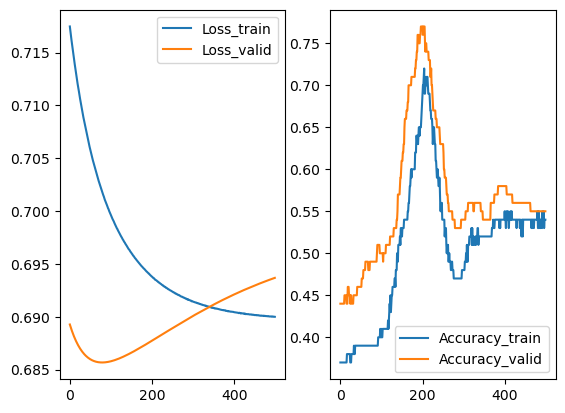

In [12]:
# Plot the loss and accuracy history
fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(loss_history_train, label="Loss_train")
ax.plot(loss_history_valid, label="Loss_valid")
ax.legend()


ax = fig.add_subplot(122)
ax.plot(accuracy_history_train, label="Accuracy_train")
ax.plot(accuracy_history_valid, label="Accuracy_valid")
ax.legend()



In [13]:
# Try a different model
model2 = torch.nn.Sequential(
    torch.nn.Linear(2,4),
    torch.nn.ReLU(),
    torch.nn.Linear(4,4),
    torch.nn.ReLU(),
    torch.nn.Linear(4,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.015)

In [14]:
# Train the model

num_epoch = 500
num_batch = num_train/batch_size

loss_history_train = np.zeros(num_epoch)
accuracy_history_train = np.zeros(num_epoch)

loss_history_valid = np.zeros(num_epoch)
accuracy_history_valid = np.zeros(num_epoch)

for epoch in range(num_epoch):
    for X_batch, y_batch in dataloader_train:
        pred = model2(X_batch)[:,0] # See one cell above for why using [:,0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_history_train[epoch] += loss.item()
        # pred>0.5 returns a boolean tensor, we need to convert it to float32 in order to compare it with y_batch.
        # .float() converts the tensor into float32
        # The .float() at the end turns is_correct into a float32 tensor. 
        # We must do this, otherwise we cannot take its mean by using .mean()
        is_correct = ((pred>0.5).float() == y_batch).float()
        accuracy_history_train[epoch] += is_correct.mean()
        
    loss_history_train[epoch] /= num_batch
    accuracy_history_train[epoch] /= num_batch
    
    pred = model2(X_valid)[:,0]
    loss = loss_fn(pred, y_valid)
    loss_history_valid[epoch] = loss.item()
    is_correct = ((pred>0.5).float() == y_valid).float() 
    accuracy_history_valid[epoch] = is_correct.mean()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss_history_train[epoch]} Accuracy {accuracy_history_train[epoch]}")

Epoch 0, Loss 0.6943359899520875 Accuracy 0.5
Epoch 10, Loss 0.6910770642757416 Accuracy 0.51
Epoch 20, Loss 0.6873595225811004 Accuracy 0.64
Epoch 30, Loss 0.6812585997581482 Accuracy 0.65
Epoch 40, Loss 0.6700192403793335 Accuracy 0.68
Epoch 50, Loss 0.6500744819641113 Accuracy 0.68
Epoch 60, Loss 0.6095121252536774 Accuracy 0.72
Epoch 70, Loss 0.5371059280633926 Accuracy 0.83
Epoch 80, Loss 0.45192167043685916 Accuracy 0.84
Epoch 90, Loss 0.38928669661283494 Accuracy 0.89
Epoch 100, Loss 0.37091651037335394 Accuracy 0.85
Epoch 110, Loss 0.3436660943925381 Accuracy 0.87
Epoch 120, Loss 0.33907064944505694 Accuracy 0.88
Epoch 130, Loss 0.3335575269162655 Accuracy 0.86
Epoch 140, Loss 0.33116481751203536 Accuracy 0.86
Epoch 150, Loss 0.33287717558443547 Accuracy 0.88
Epoch 160, Loss 0.3311958070099354 Accuracy 0.87
Epoch 170, Loss 0.3202504433318973 Accuracy 0.84
Epoch 180, Loss 0.33031394504010675 Accuracy 0.86
Epoch 190, Loss 0.3232095008343458 Accuracy 0.87
Epoch 200, Loss 0.3251308

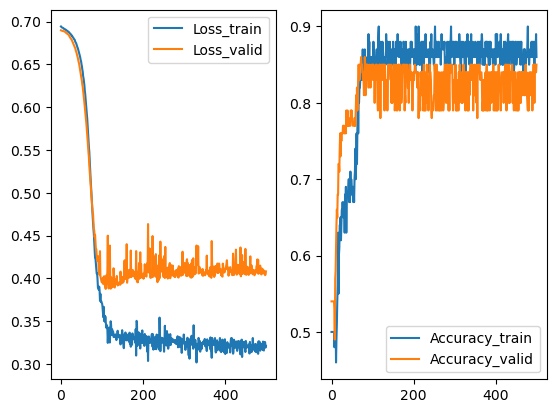

In [15]:
# Plot the loss and accuracy history
fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(loss_history_train, label="Loss_train")
ax.plot(loss_history_valid, label="Loss_valid")
ax.legend()


ax = fig.add_subplot(122)
ax.plot(accuracy_history_train, label="Accuracy_train")
ax.plot(accuracy_history_valid, label="Accuracy_valid")
ax.legend()

## Building a model with torch.nn.Module

In [16]:
# Defining a mew class
class MyModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        l1 = torch.nn.Linear(2,4)
        a1 = torch.nn.ReLU()
        l2 = torch.nn.Linear(4,4)
        a2 = torch.nn.ReLU()
        l3 = torch.nn.Linear(4,1)
        a3 = torch.nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = torch.nn.ModuleList(l)
        
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()
        

In [17]:
model3 = MyModule()
model3

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [18]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.015)

In [19]:
# Train the model

num_epoch = 500
num_batch = num_train/batch_size

loss_history_train = np.zeros(num_epoch)
accuracy_history_train = np.zeros(num_epoch)

loss_history_valid = np.zeros(num_epoch)
accuracy_history_valid = np.zeros(num_epoch)

for epoch in range(num_epoch):
    for X_batch, y_batch in dataloader_train:
        pred = model3(X_batch)[:,0] # See one cell above for why using [:,0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_history_train[epoch] += loss.item()
        # pred>0.5 returns a boolean tensor, we need to convert it to float32 in order to compare it with y_batch.
        # .float() converts the tensor into float32
        # The .float() at the end turns is_correct into a float32 tensor. 
        # We must do this, otherwise we cannot take its mean by using .mean()
        is_correct = ((pred>0.5).float() == y_batch).float()
        accuracy_history_train[epoch] += is_correct.mean()
        
    loss_history_train[epoch] /= num_batch
    accuracy_history_train[epoch] /= num_batch
    
    pred = model3(X_valid)[:,0]
    loss = loss_fn(pred, y_valid)
    loss_history_valid[epoch] = loss.item()
    is_correct = ((pred>0.5).float() == y_valid).float() 
    accuracy_history_valid[epoch] = is_correct.mean()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss_history_train[epoch]} Accuracy {accuracy_history_train[epoch]}")

Epoch 0, Loss 0.7118445813655854 Accuracy 0.5
Epoch 10, Loss 0.6866549491882324 Accuracy 0.61
Epoch 20, Loss 0.6725365936756134 Accuracy 0.62
Epoch 30, Loss 0.6476924151182175 Accuracy 0.6
Epoch 40, Loss 0.6139608478546142 Accuracy 0.66
Epoch 50, Loss 0.5838096553087234 Accuracy 0.65
Epoch 60, Loss 0.5571103654056787 Accuracy 0.67
Epoch 70, Loss 0.5294064970314503 Accuracy 0.68
Epoch 80, Loss 0.4995332655310631 Accuracy 0.69
Epoch 90, Loss 0.4772013109177351 Accuracy 0.69
Epoch 100, Loss 0.4613139377720654 Accuracy 0.69
Epoch 110, Loss 0.44929386749863626 Accuracy 0.69
Epoch 120, Loss 0.44301694775000217 Accuracy 0.68
Epoch 130, Loss 0.4375314300414175 Accuracy 0.67
Epoch 140, Loss 0.4328946222085506 Accuracy 0.71
Epoch 150, Loss 0.4299271430820227 Accuracy 0.67
Epoch 160, Loss 0.4278845395613462 Accuracy 0.68
Epoch 170, Loss 0.42466601126594467 Accuracy 0.68
Epoch 180, Loss 0.4224917461059522 Accuracy 0.71
Epoch 190, Loss 0.4208940924889612 Accuracy 0.7
Epoch 200, Loss 0.4191640088520

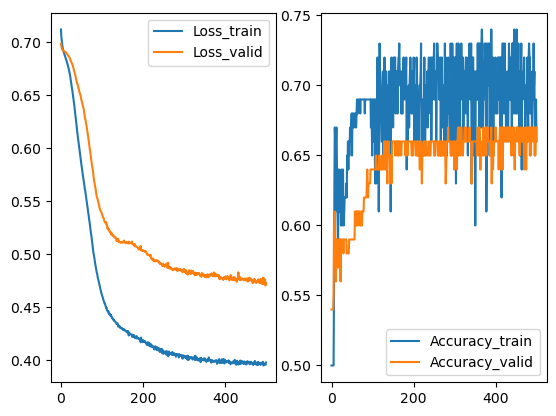

In [20]:
# Plot the loss and accuracy history
fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(loss_history_train, label="Loss_train")
ax.plot(loss_history_valid, label="Loss_valid")
ax.legend()


ax = fig.add_subplot(122)
ax.plot(accuracy_history_train, label="Accuracy_train")
ax.plot(accuracy_history_valid, label="Accuracy_valid")
ax.legend()

<AxesSubplot:>

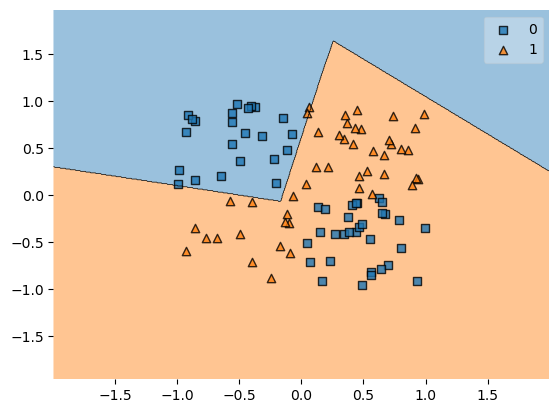

In [21]:
# Plot decision boundary
fig = plt.figure()
ax = fig.add_subplot(111)
plot_decision_regions(X=X_valid.numpy(), y=y_valid.numpy().astype(np.int32), clf=model3)

## Writing custom layers

In [22]:
# We first define a custom layer z = w(x+eps)+b, where eps is random, regarded as noise.
# A custom layer should be inherited from torch.nn.Module
# By the inheritance, we can use pytorch's utilities such as backpropagation and so on.
class NoisyLinear(torch.nn.Module):
    # Typically, the arguments for __init__() are:
        # input_size, output_size, additional_arguments
    # Here, the additional argument is noise_std
    def __init__(self, input_size, output_size, noise_std=0.1):
        # super() returns a temporary object that allows us to call methods of the parent class.
        # Don't use super.__init__(). It's wrong!
        # super().__init__() is used to call the constructor method of the parent class 
            # and initialize any attributes or methods defined in that class.
        super().__init__()
        
        # This creates a tensor of shape (input_size, output_size) with uninitialized values. 
        w = torch.Tensor(input_size, output_size)
        # This registers the weight tensor w as a learnable parameter of the custom layer.
        # This means that the parameter is included in the list of model parameters 
            # when we call the parameters() method of the module.
        self.w = torch.nn.Parameter(w)
        
        # Xavier initialization of the weight tensor
        # torch.nn.init.xavier_uniform_ modifies self.w
        # Also note that torch.nn.init.xavier_uniform returns a new tensor, which is not necessary here.
        torch.nn.init.xavier_uniform_(self.w)
        # This is a compound command.
        # It first creates a scalar tensor, uninitialized.
        # Then the value is changed to 0 by fill_(0)
        b = torch.Tensor(output_size).fill_(0)
        # This registers b as a model parameter
        self.b = torch.nn.Parameter(b)
        
        # noise_std is not a parameter to be learned. No need to use torch.nn.Parameter()
        self.noise_std = noise_std
    
    def forward(self, x, training=False):
        # When we train the model, the input x is added a noise for forward propagation.
        # When we make prediction, the input is unchanged.
        if training:
            noise = torch.normal(0.0, self.noise_std, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        
        # Note that the input should be considered as a row vector,
            # or several rows representing multiple examples
        # The weight here is defined differently from before.
        # Each column corresponds to a neuron.
        # Previously, when the input is thought of as a column vector,
            # each row of the weight matrix corresponds to a neuron.
        # The broadcasting rule makes the final addition with self.b correct:
            # Each output (row vector) is added with self.b.
        return torch.add(torch.mm(x_new, self.w), self.b)

In [23]:
# Test the custom layer
torch.manual_seed(1)
noisy_layer = NoisyLinear(4, 2)
x = torch.zeros((1,4))
# noisy_layer(x, training) automatically calls the forward method.
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=False))
print(noisy_layer(x))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [30]:
# Test the custom layer
torch.manual_seed(1)
noisy_layer = NoisyLinear(4, 2)
x = torch.zeros((3,4))
# noisy_layer(x, training) automatically calls the forward method.
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=True))
print(noisy_layer(x, training=False))
print(noisy_layer(x))

tensor([[ 0.1154, -0.0598],
        [ 0.0432, -0.0375],
        [-0.0366,  0.0022]], grad_fn=<AddBackward0>)
tensor([[ 0.1388, -0.1060],
        [ 0.0961, -0.2134],
        [-0.1558,  0.1745]], grad_fn=<AddBackward0>)
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<AddBackward0>)
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], grad_fn=<AddBackward0>)


In [24]:
# Create a model with the custom layer
# Note that the model also inherits torch.nn.Module, as the definition of the noisy layer
class MyNoisyModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = torch.nn.ReLU()
        self.l2 = NoisyLinear(4, 4)
        self.a2 = torch.nn.ReLU()
        self.l3 = torch.nn.Linear(4,1)
        self.a3 = torch.nn.Sigmoid()
        
    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        # The input x may not be a torch tensor. It may be a numpy array.
        # We need to convert it into a tensor.
        x = torch.tensor(x, dtype=torch.float32)
        # The output is 2D. Each row corresponds to an example.
        # In fact, each row has only a single entry.
        # [:, 0] converts the ouput into a 1D tensor.
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

In [25]:
torch.manual_seed(1)
model4 = MyNoisyModule()
model4

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): NoisyLinear()
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [26]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model4.parameters(), lr=0.015)

In [27]:
# Train the model

num_epoch = 500
num_batch = num_train/batch_size

loss_history_train = np.zeros(num_epoch)
accuracy_history_train = np.zeros(num_epoch)

loss_history_valid = np.zeros(num_epoch)
accuracy_history_valid = np.zeros(num_epoch)

for epoch in range(num_epoch):
    for X_batch, y_batch in dataloader_train:
        pred = model4(X_batch, True)[:,0] 
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_history_train[epoch] += loss.item()
        # pred>0.5 returns a boolean tensor, we need to convert it to float32 in order to compare it with y_batch.
        # .float() converts the tensor into float32
        # The .float() at the end turns is_correct into a float32 tensor. 
        # We must do this, otherwise we cannot take its mean by using .mean()
        is_correct = ((pred>0.5).float() == y_batch).float()
        accuracy_history_train[epoch] += is_correct.mean()
        
    loss_history_train[epoch] /= num_batch
    accuracy_history_train[epoch] /= num_batch
    
    pred = model4(X_valid)[:,0]
    loss = loss_fn(pred, y_valid)
    loss_history_valid[epoch] = loss.item()
    is_correct = ((pred>0.5).float() == y_valid).float() 
    accuracy_history_valid[epoch] = is_correct.mean()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {loss_history_train[epoch]} Accuracy {accuracy_history_train[epoch]}")

Epoch 0, Loss 0.7132087188959122 Accuracy 0.5
Epoch 10, Loss 0.6720011126995087 Accuracy 0.63
Epoch 20, Loss 0.6224192005395889 Accuracy 0.79
Epoch 30, Loss 0.494585410952568 Accuracy 0.88
Epoch 40, Loss 0.3400238010287285 Accuracy 0.92
Epoch 50, Loss 0.24425554975867272 Accuracy 0.94
Epoch 60, Loss 0.19145931493490934 Accuracy 0.96
Epoch 70, Loss 0.1614004292851314 Accuracy 0.97
Epoch 80, Loss 0.15150000948109665 Accuracy 0.95
Epoch 90, Loss 0.13755943095544354 Accuracy 0.95
Epoch 100, Loss 0.1505899299311568 Accuracy 0.94
Epoch 110, Loss 0.10142097529096646 Accuracy 0.97
Epoch 120, Loss 0.08010323439593776 Accuracy 0.97
Epoch 130, Loss 0.1098727415864414 Accuracy 0.96
Epoch 140, Loss 0.1373669643441099 Accuracy 0.94
Epoch 150, Loss 0.10525181212593453 Accuracy 0.95
Epoch 160, Loss 0.11990493735199834 Accuracy 0.93
Epoch 170, Loss 0.12034571141843116 Accuracy 0.95
Epoch 180, Loss 0.09168422051960079 Accuracy 0.97
Epoch 190, Loss 0.09517006251036947 Accuracy 0.95
Epoch 200, Loss 0.1058

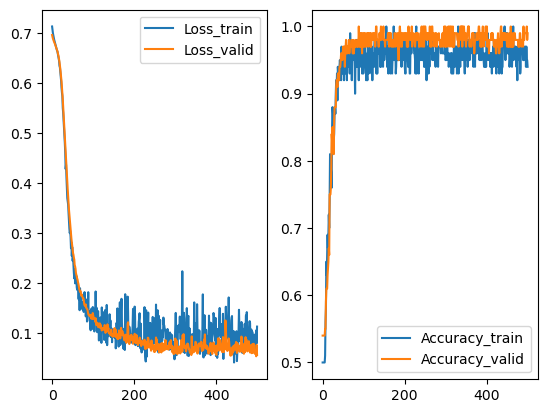

In [28]:
# Plot the loss and accuracy history
fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(loss_history_train, label="Loss_train")
ax.plot(loss_history_valid, label="Loss_valid")
ax.legend()


ax = fig.add_subplot(122)
ax.plot(accuracy_history_train, label="Accuracy_train")
ax.plot(accuracy_history_valid, label="Accuracy_valid")
ax.legend()

<AxesSubplot:>

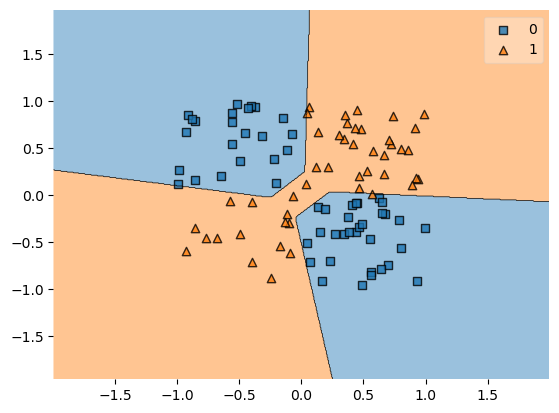

In [29]:
# Plot decision boundary
fig = plt.figure()
ax = fig.add_subplot(111)
plot_decision_regions(X=X_valid.numpy(), y=y_valid.numpy().astype(np.int32), clf=model4)